# Version-2

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import warnings
import os
from tqdm.notebook import tqdm

import re
import nltk
import distance
from fuzzywuzzy import fuzz
import texthero as hero

%matplotlib inline
warnings.filterwarnings('ignore')

## Loading data

In [2]:
df = pd.read_csv('../input/result_version_1.csv')
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [3]:
df.shape

(404290, 17)

## Data Cleaning

hero.clean pipeline:
 1. `texthero.preprocessing.fillna`
 2. `texthero.preprocessing.lowercase`
 3. `texthero.preprocessing.remove_digits`
 4. `texthero.preprocessing.remove_punctuation`
 5. `texthero.preprocessing.remove_diacritics`
 6. `texthero.preprocessing.remove_stopwords`
 7. `texthero.preprocessing.remove_whitespace`

In [4]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    return x

In [5]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [6]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


## Feature extraction

In [7]:
SAFE_DIV = 0.0001
STOP_WORDS = nltk.corpus.stopwords.words("english")

***Extracting token features***

In [9]:
def get_token_features(q1, q2):
    
    token_features = [0.0]*10
    
    q1_tokens = nltk.tokenize.TweetTokenizer().tokenize(q1)
    q2_tokens = nltk.tokenize.TweetTokenizer().tokenize(q2)

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    common_word_count = len(q1_words.intersection(q2_words))

    common_stop_count = len(q1_stops.intersection(q2_stops))

    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    
    return token_features

In [28]:
token_features = np.zeros((df.shape[0], 10))

for index, (q1, q2) in tqdm(enumerate(zip(df['question1'], df['question2'])), total=df.shape[0]):
    
    token_features[index] = get_token_features(q1, q2)

In [36]:
df["cwc_min"]       = token_features[:, 0]
df["cwc_max"]       = token_features[:, 1]
df["csc_min"]       = token_features[:, 2]
df["csc_max"]       = token_features[:, 3]
df["ctc_min"]       = token_features[:, 4]
df["ctc_max"]       = token_features[:, 5]
df["last_word_eq"]  = token_features[:, 6]
df["first_word_eq"] = token_features[:, 7]
df["abs_len_diff"]  = token_features[:, 8]
df["mean_len"]      = token_features[:, 9]

***Extracting Fuzzy features***

In [37]:
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

In [44]:
token_set_ratio         = np.zeros((df.shape[0]))
token_sort_ratio        = np.zeros((df.shape[0]))
fuzz_ratio              = np.zeros((df.shape[0]))
fuzz_partial_ratio      = np.zeros((df.shape[0]))
fuzz_partial_sort_ratio = np.zeros((df.shape[0]))
fuzz_partial_set_ratio  = np.zeros((df.shape[0]))
longest_substr_ratio    = np.zeros((df.shape[0]))

for index, (q1, q2) in tqdm(enumerate(zip(df['question1'], df['question2'])), total=df.shape[0]):
    
    token_set_ratio[index]         = fuzz.token_set_ratio(q1, q2)
    token_sort_ratio[index]        = fuzz.token_sort_ratio(q1,q2)
    fuzz_ratio[index]              = fuzz.QRatio(q1, q2)
    fuzz_partial_ratio[index]      = fuzz.partial_ratio(q1, q2)
    fuzz_partial_sort_ratio[index] = fuzz.partial_token_sort_ratio(q1, q2)
    fuzz_partial_set_ratio[index]  = fuzz.partial_token_set_ratio(q1, q2)
    longest_substr_ratio[index]    = get_longest_substr_ratio(q1, q2)

In [46]:
df["token_set_ratio"]         = token_set_ratio
df["token_sort_ratio"]        = token_sort_ratio
df["fuzz_ratio"]              = fuzz_ratio
df["fuzz_partial_ratio"]      = fuzz_partial_ratio
df["fuzz_partial_sort_ratio"] = fuzz_partial_sort_ratio
df["fuzz_partial_set_ratio"]  = fuzz_partial_set_ratio
df["longest_substr_ratio"]    = longest_substr_ratio

In [47]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_sort_ratio,fuzz_partial_set_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,1.0,2.0,14.0,100.0,93.0,93.0,98.0,89.0,100.0,0.965517
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4,1,51,88,...,1.0,5.0,13.5,86.0,63.0,66.0,75.0,75.0,100.0,0.576923


## Analysing all numeric features distributions

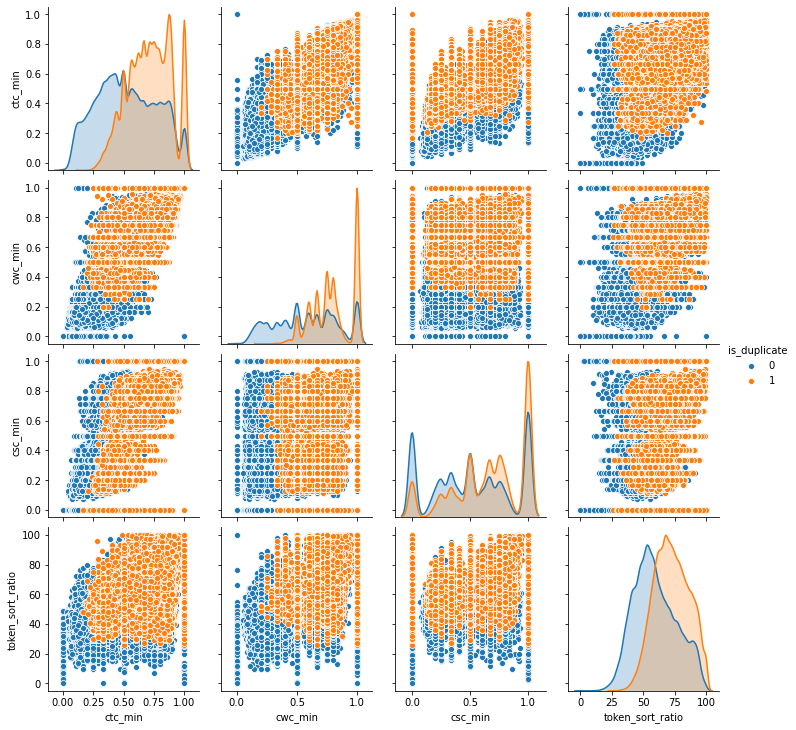

In [50]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])

In [57]:
cols = df.columns.values[6:]
cols.shape

(28,)

In [72]:
plt.setp?

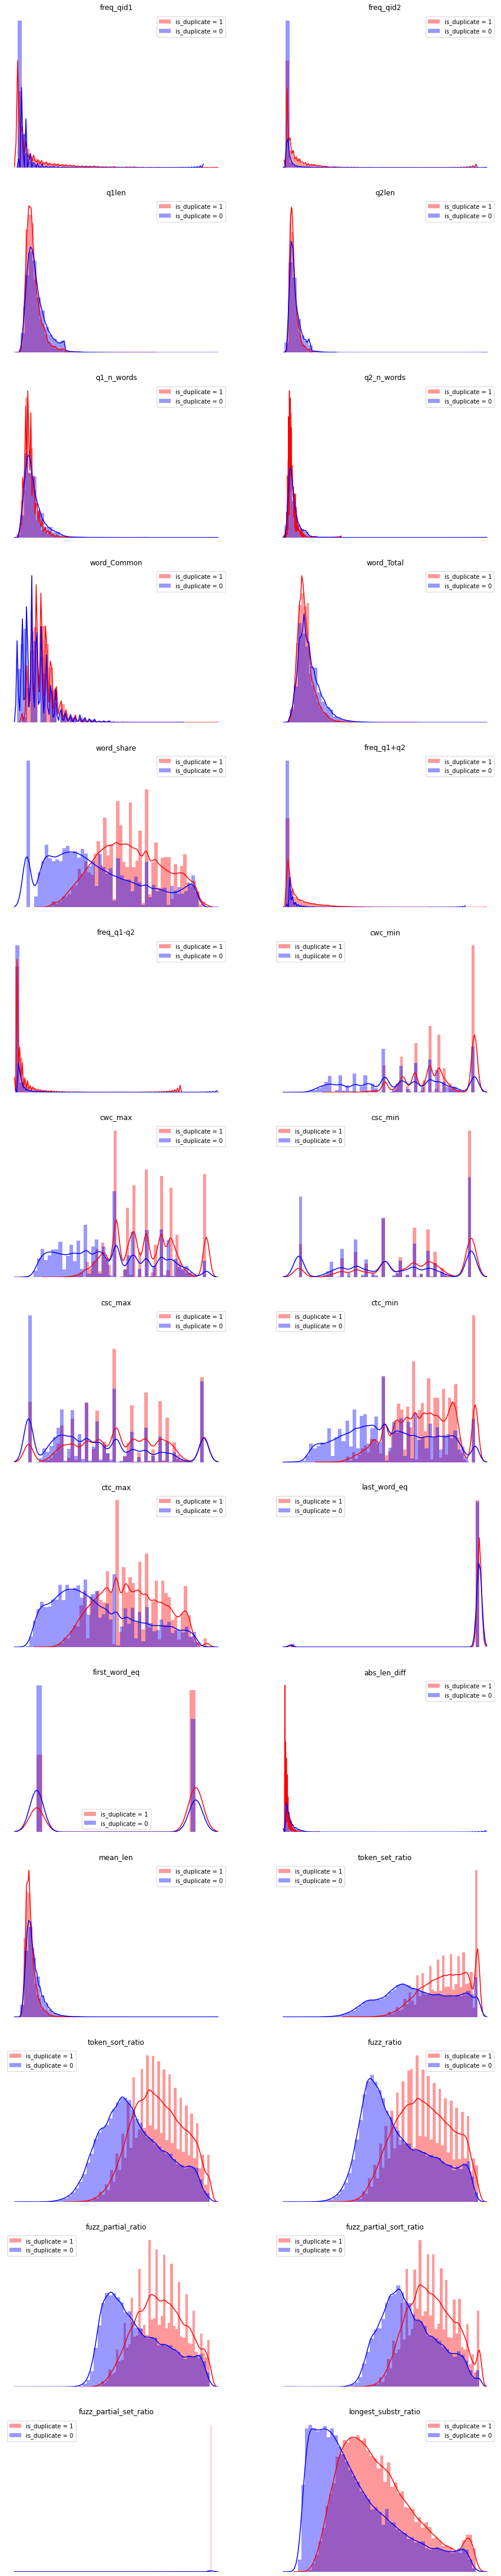

In [74]:
plt.figure(figsize=(15, 80))
for index, col in enumerate(cols):
    plt.subplot(14,2,index+1)
    sns.distplot(df[df['is_duplicate'] == 1.0][col][0:] , label = "is_duplicate = 1", color = 'red')
    sns.distplot(df[df['is_duplicate'] == 0.0][col][0:] , label = "is_duplicate = 0" , color = 'blue' )
    plt.legend()
    plt.axis('off')
    plt.title(col)

Almost every feature is providing useful information and are found to be extremely useful except for "fuzz_partial_set_ratio" as hence we will drop it.

In [77]:
df.drop(columns='fuzz_partial_set_ratio', inplace=True)

## Colinearity Analysis

<AxesSubplot:>

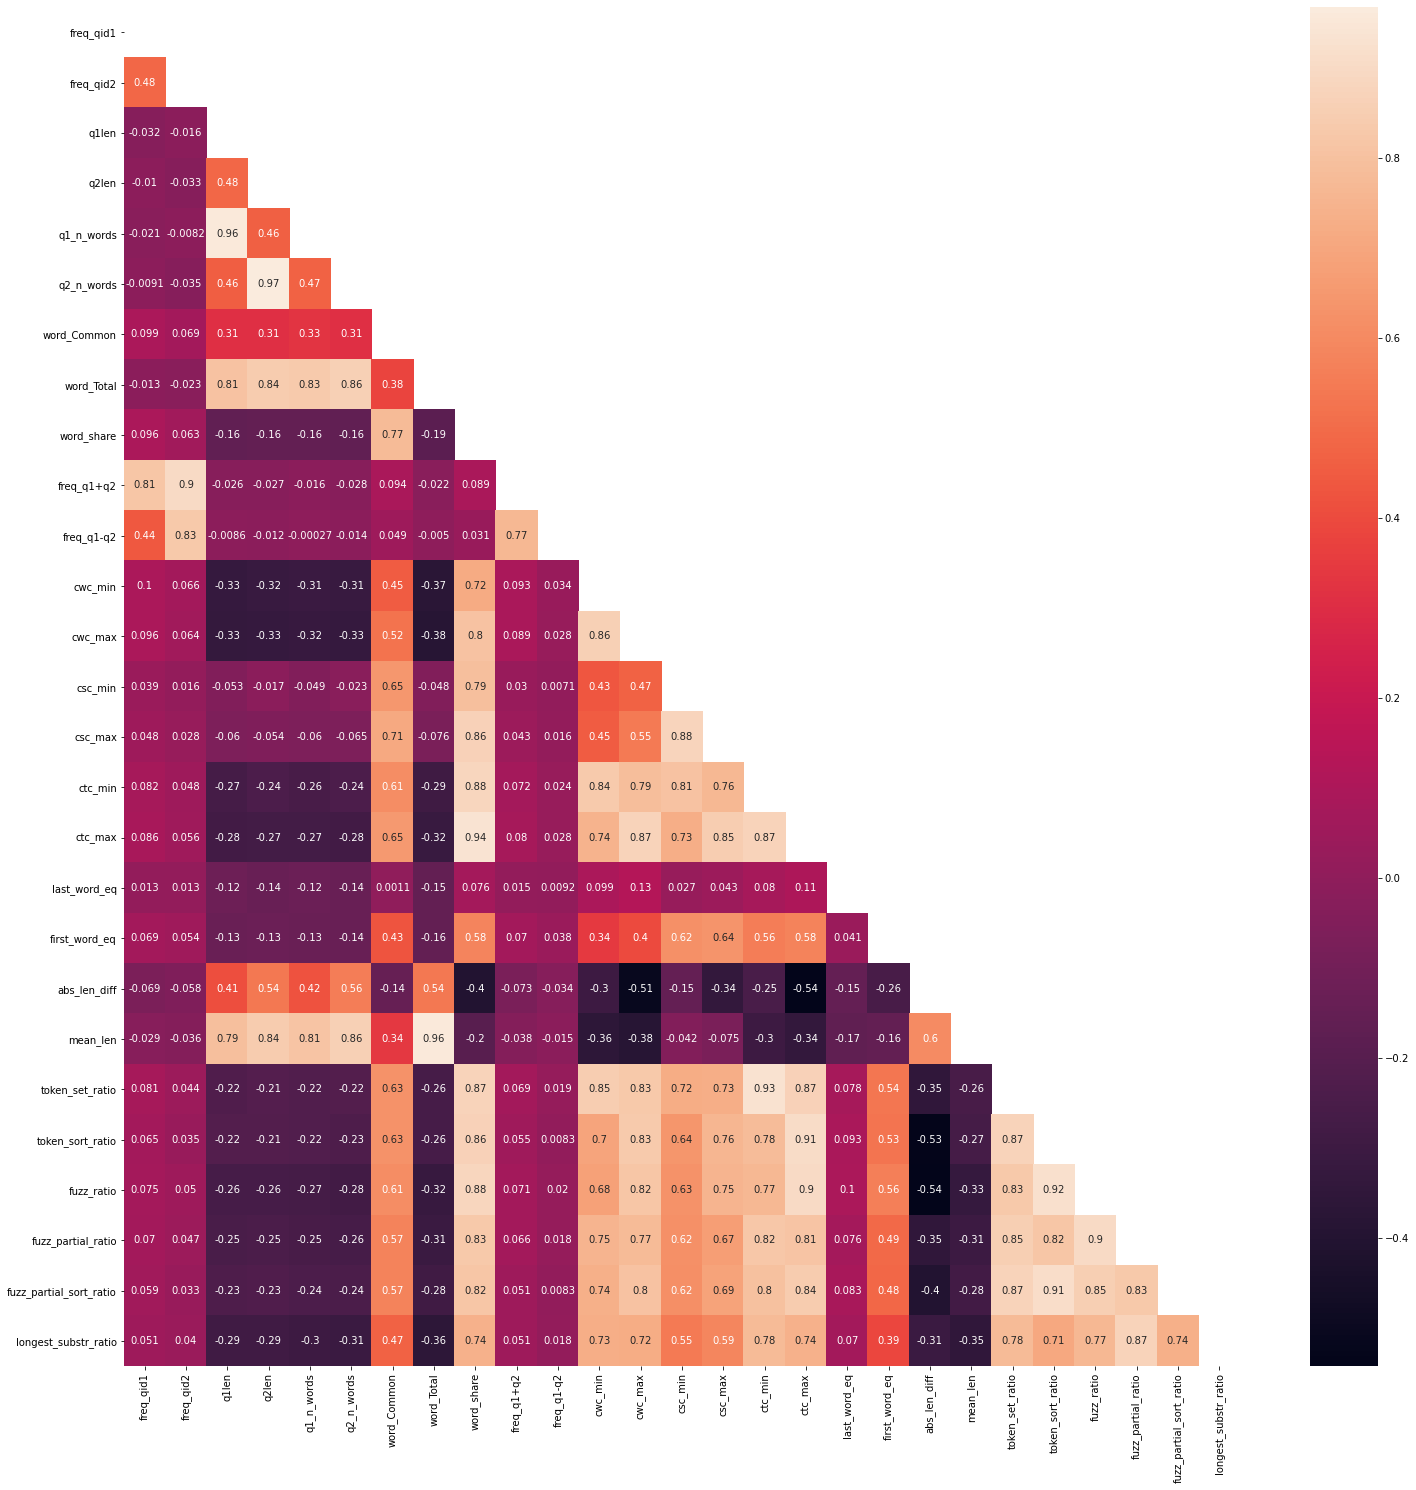

In [90]:
cols = df.columns.values[6:]

mask = np.ones((cols.shape[0], cols.shape[0]))
lt = np.triu(mask)

plt.figure(figsize=(25,25))
sns.heatmap(df[cols].corr(), annot=True, mask=lt)

As observed we have huge collinearity in some features and hence we will now proceed for feature selection.

## Logistic regression based Recursive Feature Elemination

In [115]:
from sklearn import linear_model, metrics, feature_selection

In [116]:
model = linear_model.LogisticRegression()

In [135]:
ref = feature_selection.RFE(estimator=model, n_features_to_select=10, verbose=10)

In [136]:
selected = ref.fit_transform(df.loc[:, cols], df['is_duplicate'])

Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.


## Checking correlation of selected features

<AxesSubplot:>

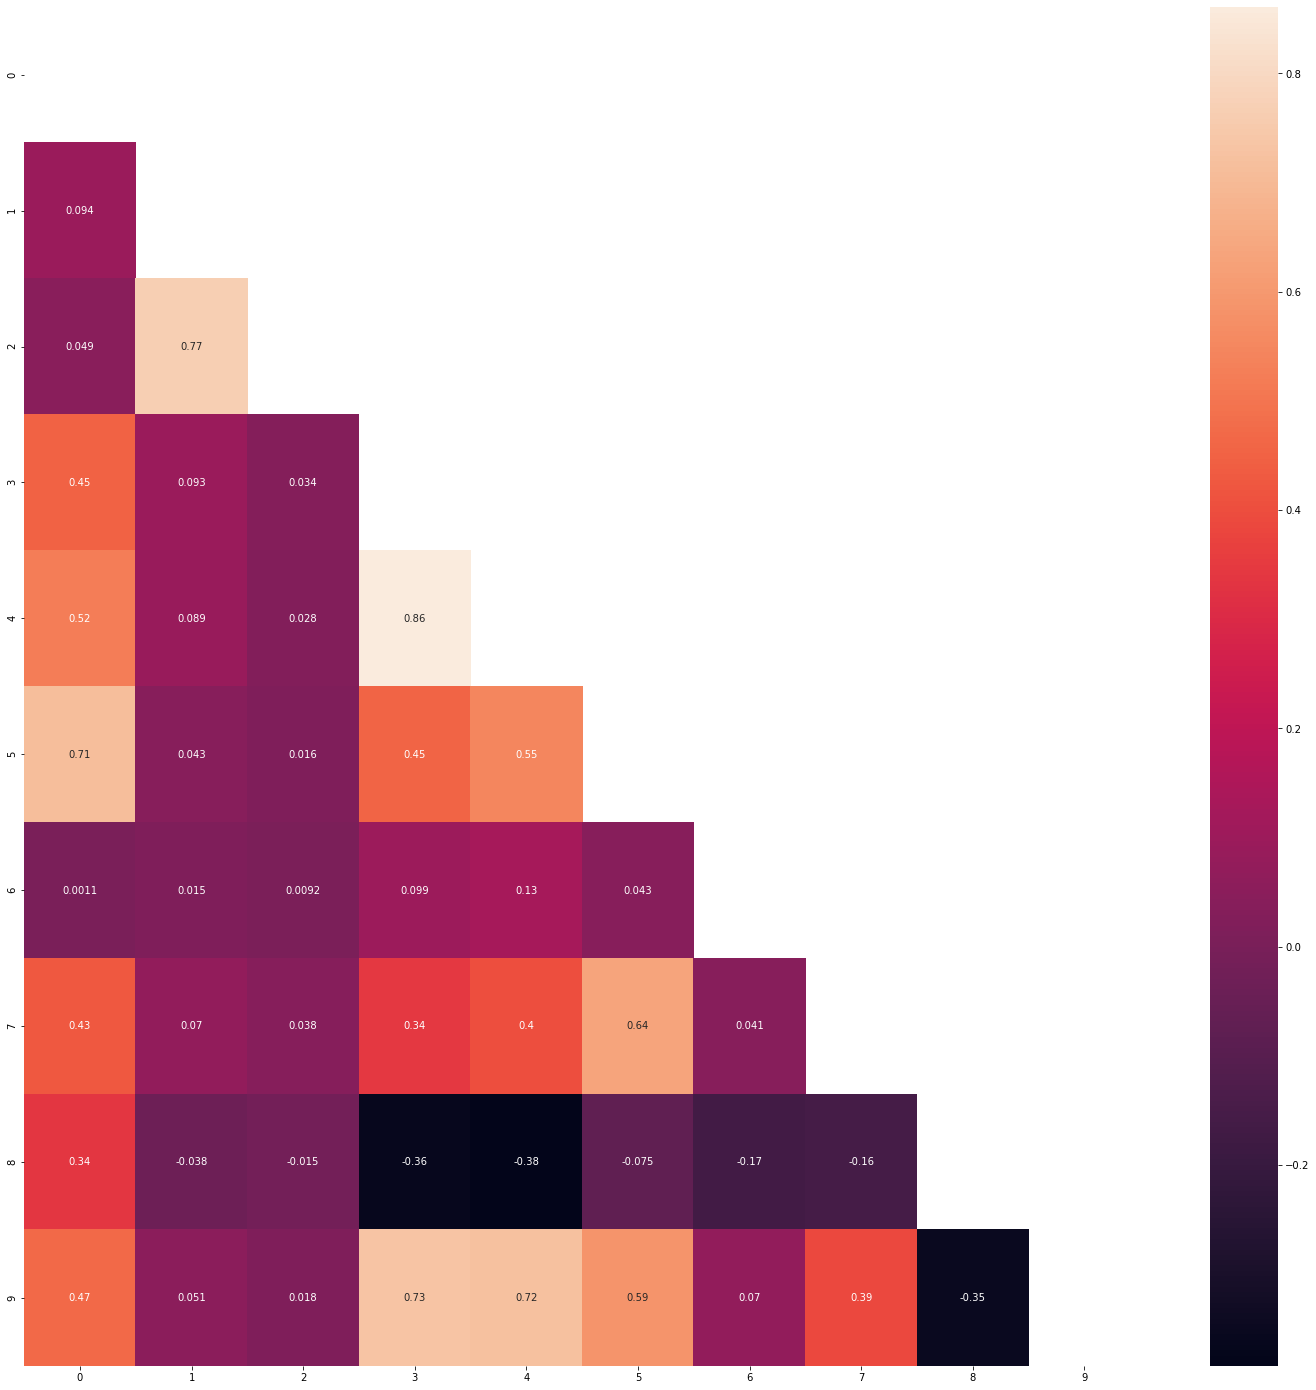

In [137]:
final = pd.DataFrame(selected)

mask = np.ones((final.shape[1], final.shape[1]))
lt = np.triu(mask)

plt.figure(figsize=(25,25))
sns.heatmap(final.corr(), annot=True, mask=lt)

With we have completed feature selection and finally we export this dataset.

In [154]:
final_df = df[df.columns.values[:6]].join(final)

cols = list(final_df.columns)
for i in range(len(cols)):
    if str(cols[i]).isnumeric():
        cols[i] = f'selected_{i-5}'
        
final_df.columns = cols
final_df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,selected_1,selected_2,selected_3,selected_4,selected_5,selected_6,selected_7,selected_8,selected_9,selected_10
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,10.0,2.0,0.0,0.999983,0.857131,0.999983,1.0,1.0,14.0,0.965517
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,4.0,5.0,3.0,0.857131,0.499996,0.499988,1.0,1.0,13.5,0.576923


In [155]:
final_df.to_csv('../input/result_version_2.csv', index=False)